In [1]:
from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load training data

In [3]:
chunks_matfile = io.loadmat('chunks_gb/ksenia_long_1.mat')
data_g = chunks_matfile['chunks_good']
data_b = chunks_matfile['chunks_bad']

data = np.concatenate((data_g, data_b))
print(data.shape)

(40230, 24, 250)


In [4]:
labels = np.zeros((data.shape[0],2))

labels[0:data_g.shape[0],0] = 1
labels[data_b.shape[0]:,1] = 1

print(sum(labels))

[ 20115.  20115.]


# Load validation data

In [5]:
chunks_matfile = io.loadmat('chunks_gb/ksenia_long_2val.mat')
data_g = chunks_matfile['chunks_good']
data_b = chunks_matfile['chunks_bad']

data_val = np.concatenate((data_g, data_b))
print(data_val.shape)

labels_val = np.zeros((data_val.shape[0],2))

labels_val[0:data_g.shape[0],0] = 1
labels_val[data_b.shape[0]:,1] = 1

print(sum(labels_val))

(13324, 24, 250)
[ 6662.  6662.]


In [11]:
data_val.shape

(13324, 250, 24)

In [17]:
data_val_slice = data_val[0,:,:]
data_val_slice.shape

(250, 24)

In [28]:
#window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')[source]¶

In [39]:
from scipy import signal

In [75]:
f, t, Sxx = signal.spectrogram(data_val_slice, 250, nperseg=32, nfft=None, axis = 0)

In [76]:
f.shape

(17,)

In [77]:
t.shape

(8,)

In [78]:
Sxx.shape

(17, 24, 8)

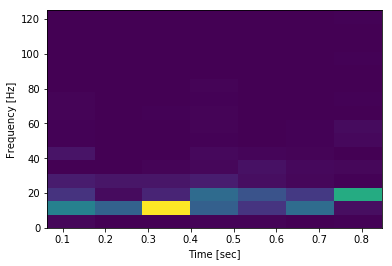

In [79]:
plt.pcolormesh(t, f, Sxx[:,0,:])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [81]:
input_size = Sxx.shape

(17, 24, 8)

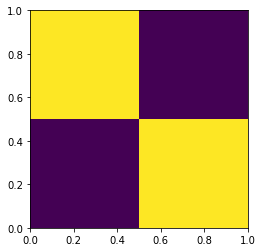

In [6]:
plt.imshow(labels_val, extent=[0, 1, 0, 1])

In [7]:
data_b.shape

(6662, 24, 250)

In [8]:
data_g.shape

(6662, 24, 250)

In [9]:
data = np.swapaxes(data,1,2)
data_val = np.swapaxes(data_val,1,2)

In [10]:
from keras.layers import Convolution1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [76]:
slice_len = 250

nb_filters = 10
kernel_size = 5

conv1d_act = "relu"

dense1_n = 20
dense1_act = "relu"

dense2_n = 20
dense2_act = "relu"

do = 0

path_to_save_model = 'testmodel'

In [81]:
input_seq = Input(shape=(slice_len, 24))

convolved = Convolution1D(nb_filters, kernel_size, border_mode="same", activation=conv1d_act)(input_seq)
pooled = GlobalMaxPooling1D()(convolved)

dense1 = Dense(dense1_n, activation=dense1_act)(pooled)
dense1do = Dropout(do)(dense1)

dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
dense2do = Dropout(do)(dense2)

out = Dense(2, activation='softmax')(dense2do)

model = Model(input=input_seq, output=out)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

from keras.callbacks import EarlyStopping, ModelCheckpoint

#nb_epoch = 100000
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_categorical_accuracy', verbose=1,
                               save_best_only=True, mode='auto', period=1)

samples_per_epoch = 3000
nb_epoch = 30



C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 5, activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [ ]:
history = model.fit(data, labels, validation_data=(data_val,labels_val), batch_size=32, epochs=100, verbose=1,)

Train on 40230 samples, validate on 13324 samples
Epoch 1/100
  352/40230 [..............................] - ETA: 161s - loss: 8.6543 - categorical_accuracy: 0.4631

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.596411). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.298705). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 23s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 2/100
40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 3/100
40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 4/100
40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 5/100
  448/40230 [..............................] - ETA: 41s - loss: 7.7712 - categorical_accuracy: 0.5179

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.263188). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132094). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 6/100
40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 7/100
  512/40230 [..............................] - ETA: 33s - loss: 8.2479 - categorical_accuracy: 0.4883

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183128). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107575). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 8/100
40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 9/100
  480/40230 [..............................] - ETA: 59s - loss: 7.9919 - categorical_accuracy: 0.5042

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.330231). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.251671). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173111). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 10/100
40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 11/100
  480/40230 [..............................] - ETA: 84s - loss: 8.1934 - categorical_accuracy: 0.4917 

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.497350). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.404285). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.311220). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156110). Check your callbacks.
  % delta_t_median)


40230/40230 [==============================] - 24s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 12/100
40230/40230 [==============================] - 22s - loss: 8.0590 - categorical_accuracy: 0.5000 - val_loss: 8.0590 - val_categorical_accuracy: 0.5000
Epoch 13/100
40224/40230 [============================>.] - ETA: 0s - loss: 8.0586 - categorical_accuracy: 0.5000

In [59]:
test = np.array([[1, 2, 3],[4, 5, 6]])
test
test.shape
np.swapaxes(test,0,1)

array([[1, 2, 3],
       [4, 5, 6]])

array([[1, 4],
       [2, 5],
       [3, 6]])

In [ ]:
samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=1000, 